## Support Vector Machines (SVM)

Support vector machines (SVM) algorithm is a <b>non-probabilistic model</b> that can be used to solve both regression and classification tasks.

Support vectors are points that lie on the marginal plane that is parallel to the hyperplane.

SVM is mostly suitable for linearly seperable points, but SVM can also be used for non-linearly seperable points by using the kernel trick.

<b>Assumptions of SVM</b>:

1. Support vectors are the most useful data points, which are most likely to be incorrectly classified.

2. Data is independent and identically distributed

<b>Requirement of feature scaling: Yes</b>

<b>Robust to outliers: No </b>

<b>Is multicollinearity an issue?: No </b>

<b>Advantages of SVM:</b>
1. Regularization capabilities which prevents model overfitting

2. Ability to handle non-linear data using kernel trick

3. Solves both classification and regression tasks

4. Small change in data points does not result changes in hyperplane of model, thus SVM model is considered stable.

5. Works well on high-dimensional features

6. Effective when the number of dimensions is greater than the number of samples.

7. Memory efficient, as it only uses subset of training points in the decision function (support vectors)

<b>Disadvantages of SVM:</b>
1. Selection of kernel is difficult, as high-dimensional kernels may result in too many support vectors which reduces speed of model training

2. Memory requirement is large, as support vectors grow in size with training dataset size.

3. Longer training time required on large datasets.

4. Difficult to interpret

5. Not robust to outliers

6. Probability estimates not provided directly, instead they are obtained through cross validation which is computationally expensive

<b>Time complexity of model training: O(n^2)</b>

<b>Time complexity of model prediction: O(s*d)</b>

<b>Space complexity of model prediction: O(s)</b>

n - Number of training samples

s - Number of support vectors

d - Number of features

## Hard margin vs Soft margin in SVM

When data points are perfectly linearly separable, hard margin objective can be used as follows for model training (Max-margin classifier):

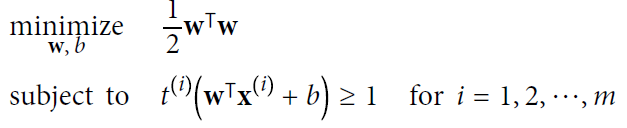

- Summation of squared coefficients equals to one
- distance of points from hyperplane to points are orthogonal and greater than or equal to 1

However, when data points are not linearly separable, soft margin objective can be used as follows for model training, which allows better bias-variance tradeoff:

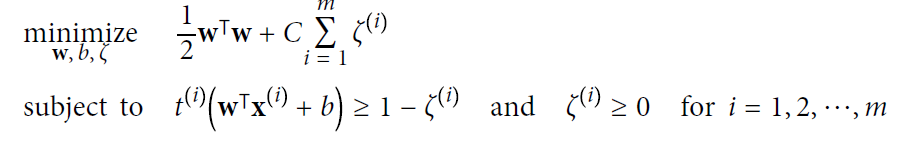

- Summation of squared coefficients equals to one
- Summation of epsilon terms less than or equal to C
- distance of points from hyperplane to points are orthogonal and greater than or equal to 1 - epsilon

Note that soft margin objective introduces two new hyperparameters in sklearn:
1. <b>C</b>: Regularization hyperparameter. The larger the value of C, the less regularized the SVM model is.
2. <b>epsilon</b>: Controls distance between hyperplane and a parallel margin plane (For regression only)

## Dual vs Primal Form of SVM

Given that both hard margin and soft margin objectives are convex quadratic optimization problems with linear constraints, they are known as <b>Primal form of SVM</b>.

A different method to rexpress both hard and soft margin objectives is by using <b>dual form of SVM</b>, which gives the same solution as primal form of SVM.

<b>Dual form of SVM is suitable to use under the following scenarios</b>:
1. Using kernel tricks on non-linearly separable data points
2. Number of training instances smaller than number of features

<b>Primal form of SVM is suitable to use under the following scenarios</b>:
1. Data points are linearly separable
2. Number of training instances larger than number of features

Note that the option of using dual vs primal form is only available in <b>LinearSVC and LinearSVR</b> algorithm for sklearn.

## Kernel Trick of SVM

SVM kernels convert lower-dimension data to higher dimension data for creating hyperplanes to seperate points without requiring additional calculation of distances by using pre-defined mathematical functions.

These kernel functions are based on two points only (inner dot product to reduce complexity of feature space and computation time), which quantifies similarity between low dimensional space and high dimensional space

The following are the most common kernels available in SVM with its following formulas:
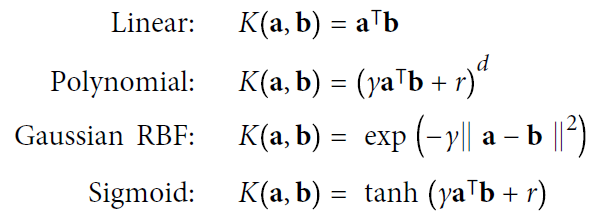

Note that the use of kernel types in SVM requires hyperparameter tuning.

<b>Gamma hyperparameter, γ</b> for poly, rbf and sigmoid defines how far the influence of single training example reaches.

The larger the value of gamma, SVM is more prone to model overfitting and vice versa.

In [1]:
# Import all required Python libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_wine
from skopt import BayesSearchCV
from sklearn.svm import SVC, LinearSVR
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from transformers import OutlierCapTransformer, ScalingTransformer

More details related to Exploratory Data Analysis for both regression and classification problem statement can be found in the following Jupyter Notebook within the same folder: EDA_Regression.ipynb and EDA_Classification.ipynb

## SVM for regression

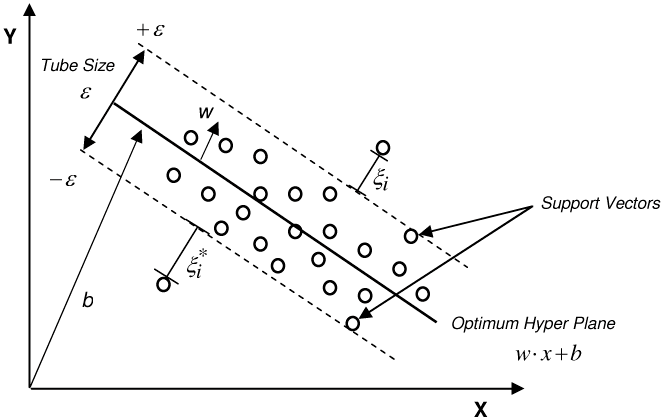

<b>Main objective of SVM for regression</b>: Create a hyperplane with parallel margin planes that have the <b>smallest margin distance</b>, where majority of the points lie in between margin planes.

<b>Important hyperparameters for SVR</b>:
1. C: Regularization strength value between 0 and inf. The larger the value of C, the weaker the regularization strength.
2. kernel: Kernel type to use for SVM. (linear, rbf, poly, sigmoid)
3. degree: Degree of polynomial kernel function.
4. gamma: Kernel coefficient for rbf, polynomial and sigmoid kernel.

<b>Note that SVR models are suitable for smaller datasets with number of samples less than 10000.</b>

For larger datasets, a suitable alternative is to use LinearSVR after <b>Nystroem transformer for non-linear kernels</b>.
Nystroem transformer creates additional features, which may not be directly interpretable.

<b>Important hyperparameters for LinearSVR</b>:
1. C: Regularization strength value between 0 and inf. The larger the value of C, the weaker the regularization strength.
2. dual: Set to False when number of samples more than number of features, otherwise set to True.
3. loss: epsilon_insensitive represents l1 loss and squared_epsilon_insensitive represents l2 loss.

In [2]:
data = fetch_california_housing()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Median House Value ($100000)'

In [3]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = KFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_rmse, test_rmse = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        if search_space != None:
            search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,
                                   scoring= make_scorer(mean_squared_error, squared=False),refit=True, n_jobs=3)
            search.fit(X_train,y_train)
            val_rmse.append(search.best_score_)
            print(f'Validation RMSE for fold {fold+1}:',search.best_score_)
            print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
            y_pred = search.best_estimator_.predict(X_test)
        else:
            cv_results = cross_validate(pipeline, X_train, y_train, scoring = {'rmse': make_scorer(mean_squared_error, squared=False)}, cv=3, n_jobs=3)
            val_rmse.append(cv_results['test_rmse'].mean())
            print(f'Validation RMSE for fold {fold+1}:', cv_results['test_rmse'].mean())
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
        test_rmse.append(mean_squared_error(y_test,y_pred,squared=False))
        print(f'Test RMSE for fold {fold+1}:',mean_squared_error(y_test,y_pred,squared=False))
    print('----------------------')
    print('Average validation RMSE score:', np.mean(val_rmse))
    print('Average test RMSE score:', np.mean(test_rmse))

In [4]:
reg = LinearSVR(loss='squared_epsilon_insensitive', dual=False, max_iter=10000, random_state=120)
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Robust')))
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__C'] = Real(0.0001,1,'log-uniform')
nested_cv(X, y, pipeline, search_space)

Validation RMSE for fold 1: 0.9105730988304888
Best hyperparameters for fold 1: OrderedDict([('regression__C', 0.00011367080483163687)])
Test RMSE for fold 1: 0.8517570131935915
Validation RMSE for fold 2: 0.8977009705685788
Best hyperparameters for fold 2: OrderedDict([('regression__C', 0.00012061070439924977)])
Test RMSE for fold 2: 0.8683618999867538
Validation RMSE for fold 3: 0.8451733325336044
Best hyperparameters for fold 3: OrderedDict([('regression__C', 0.00015823877118502418)])
Test RMSE for fold 3: 0.8616445163125029
Validation RMSE for fold 4: 0.807294566599514
Best hyperparameters for fold 4: OrderedDict([('regression__C', 0.0002136683856428913)])
Test RMSE for fold 4: 0.7871689080519074
Validation RMSE for fold 5: 0.7446140005232869
Best hyperparameters for fold 5: OrderedDict([('regression__C', 0.0004901286140468143)])
Test RMSE for fold 5: 0.7207769220133554
Validation RMSE for fold 6: 0.7700029307741286
Best hyperparameters for fold 6: OrderedDict([('regression__C', 0.

## SVM for classification

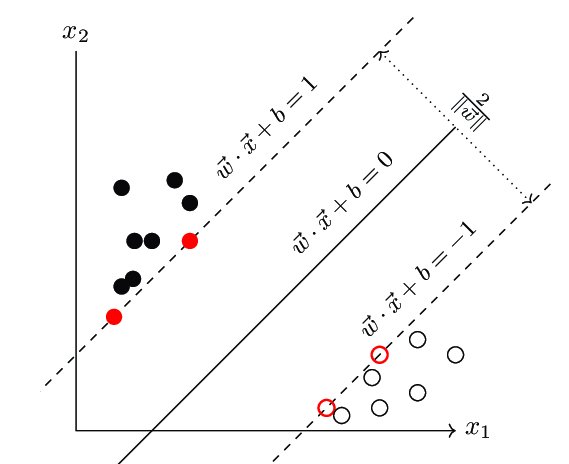

<b>Main objective of SVM for classification</b>: Create a hyperplane with parallel margin planes that passes through the nearest point for every class with <b>largest margin distance</b>.

<b>Important hyperparameters for SVC</b>:
1. C: Regularization strength value between 0 and inf. The larger the value of C, the weaker the regularization strength.
2. kernel: Kernel type to use for SVM. (linear, rbf, poly, sigmoid)
3. degree: Degree of polynomial kernel function.
4. gamma: Kernel coefficient for rbf, polynomial and sigmoid kernel.
5. class_weight: Weights for various target classes.

<b>Note that SVC models are suitable for smaller datasets with number of samples less than 10000.</b>

For larger datasets, a suitable alternative is to use LinearSVC after <b>Nystroem transformer for non-linear kernels</b>.
Nystroem transformer creates additional features, which may not be directly interpretable.

<b>Important hyperparameters for LinearSVC</b>:
1. C: Regularization strength value between 0 and inf. The larger the value of C, the weaker the regularization strength.
2. dual: Set to False when number of samples more than number of features, otherwise set to True.
3. penalty: norm used in penalization (l1 vs l2)
4. loss: loss function used (hinge, squared_hinge) - <b>Note that combination of l1 and hinge is not supported</b>.
5. class_weight: Weights for various target classes.

<b>Methods to handle imbalanced dataset for classification</b>:
1. Assign class weights to model
2. Resampling techniques (Oversampling/Combination of Oversampling and Undersampling - Less suitable for larger datasets due to high time complexity)

In [5]:
data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Wine_Class'

In [6]:
X.nunique()

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
dtype: int64

In [7]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_f1, test_f1 = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_f1.append(search.best_score_)
        print(f'Validation F1 score for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_f1.append(f1_score(y_test,y_pred, average='macro'))
        print(f'Test F1 score for fold {fold+1}:',f1_score(y_test,y_pred, average='macro'))
        print()
        cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cmd.ax_.set_title(f"Confusion Matrix - SVC (Fold {fold+1})")
        plt.grid(False)
        plt.show()
        print()
    print('----------------------')
    print('Average validation F1 score:', np.mean(val_f1))
    print('Average test F1 score:', np.mean(test_f1))

Validation F1 score for fold 1: 0.9626375088046915
Best hyperparameters for fold 1: OrderedDict([('classification__C', 0.26146882984490394), ('classification__degree', 4), ('classification__gamma', 'auto'), ('classification__kernel', 'rbf')])
Test F1 score for fold 1: 1.0



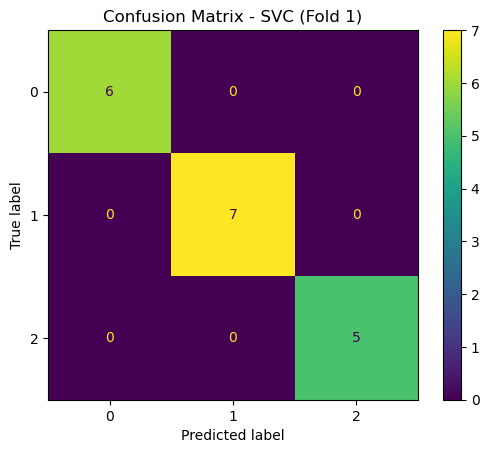


Validation F1 score for fold 2: 0.9744542757860835
Best hyperparameters for fold 2: OrderedDict([('classification__C', 0.12698890958357817), ('classification__degree', 3), ('classification__gamma', 'auto'), ('classification__kernel', 'linear')])
Test F1 score for fold 2: 1.0



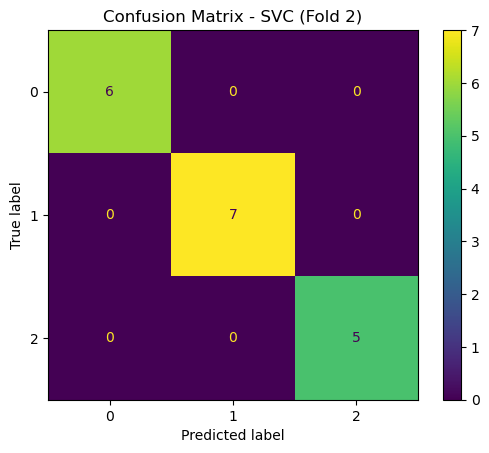


Validation F1 score for fold 3: 0.9502065655461621
Best hyperparameters for fold 3: OrderedDict([('classification__C', 0.2159619142150118), ('classification__degree', 2), ('classification__gamma', 'scale'), ('classification__kernel', 'rbf')])
Test F1 score for fold 3: 1.0



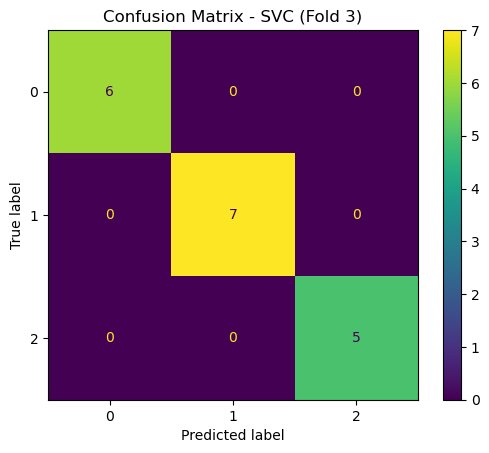


Validation F1 score for fold 4: 0.9688890583947792
Best hyperparameters for fold 4: OrderedDict([('classification__C', 0.033626117952231006), ('classification__degree', 4), ('classification__gamma', 'scale'), ('classification__kernel', 'linear')])
Test F1 score for fold 4: 1.0



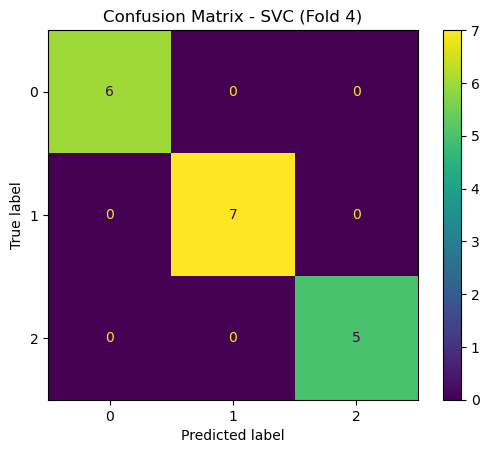


Validation F1 score for fold 5: 0.9692257440988092
Best hyperparameters for fold 5: OrderedDict([('classification__C', 0.18043613647872778), ('classification__degree', 5), ('classification__gamma', 'scale'), ('classification__kernel', 'rbf')])
Test F1 score for fold 5: 1.0



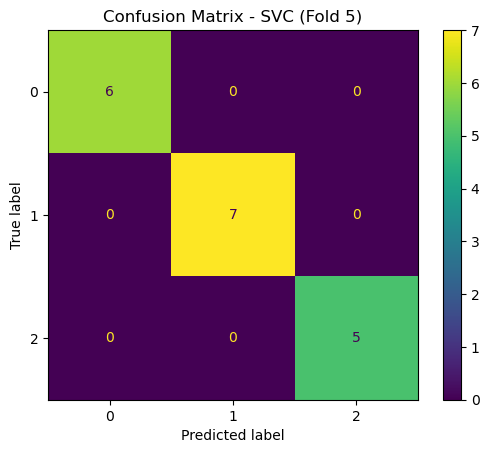


Validation F1 score for fold 6: 0.9750415638414023
Best hyperparameters for fold 6: OrderedDict([('classification__C', 0.8797619897057302), ('classification__degree', 3), ('classification__gamma', 'scale'), ('classification__kernel', 'linear')])
Test F1 score for fold 6: 0.9440559440559441



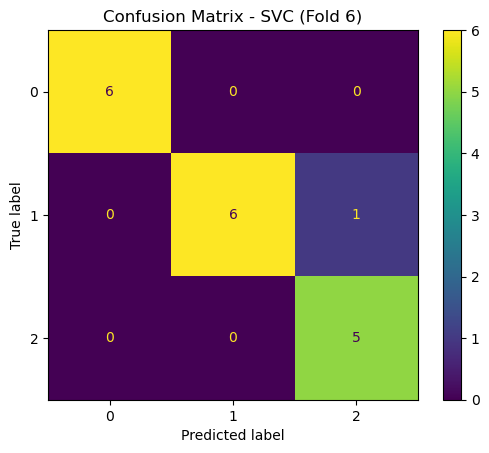


Validation F1 score for fold 7: 0.9874338569735887
Best hyperparameters for fold 7: OrderedDict([('classification__C', 0.48580419486048404), ('classification__degree', 5), ('classification__gamma', 'scale'), ('classification__kernel', 'rbf')])
Test F1 score for fold 7: 0.890993265993266



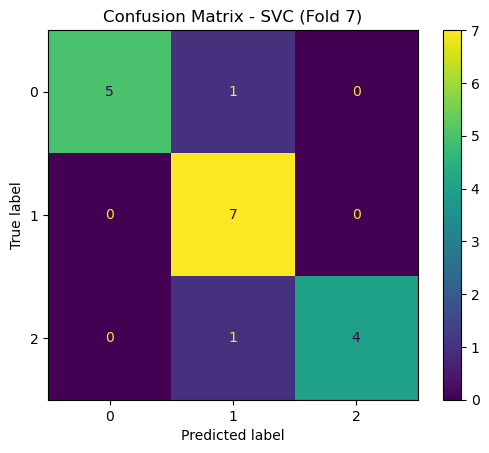


Validation F1 score for fold 8: 0.9688200922881229
Best hyperparameters for fold 8: OrderedDict([('classification__C', 0.16668027446539616), ('classification__degree', 5), ('classification__gamma', 'auto'), ('classification__kernel', 'linear')])
Test F1 score for fold 8: 1.0



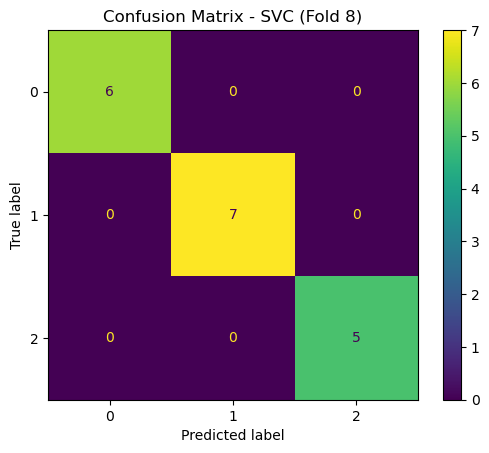


Validation F1 score for fold 9: 0.9693449671056162
Best hyperparameters for fold 9: OrderedDict([('classification__C', 0.5377911013115001), ('classification__degree', 2), ('classification__gamma', 'scale'), ('classification__kernel', 'rbf')])
Test F1 score for fold 9: 1.0



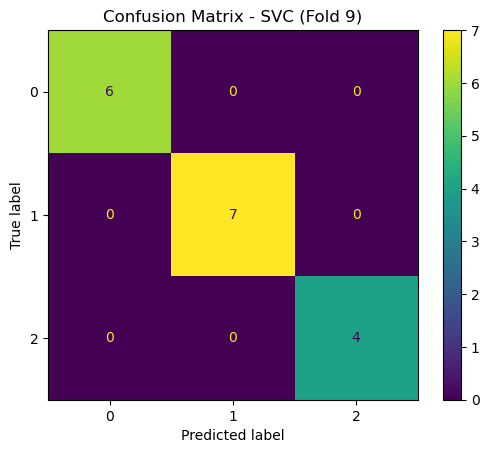


Validation F1 score for fold 10: 0.9823395525851666
Best hyperparameters for fold 10: OrderedDict([('classification__C', 0.2999766689226948), ('classification__degree', 4), ('classification__gamma', 'scale'), ('classification__kernel', 'rbf')])
Test F1 score for fold 10: 0.9407407407407408



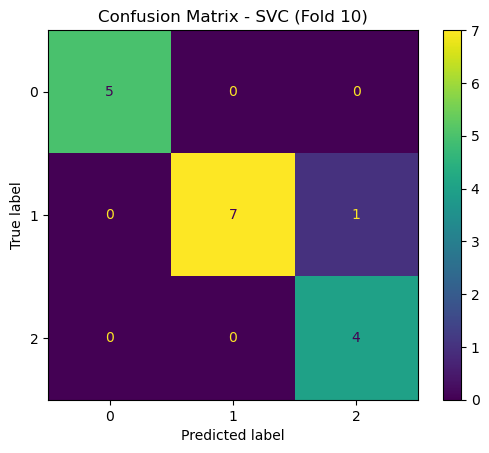


----------------------
Average validation F1 score: 0.9708393185424422
Average test F1 score: 0.9775789950789951


In [8]:
clf = SVC(random_state=120, class_weight='balanced')
pipeline = Pipeline(steps=[])
pipeline.steps.append(['outlier_capping',OutlierCapTransformer(X.columns.tolist())])
pipeline.steps.append(('scaling',ScalingTransformer('Robust')))
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['classification__C'] = Real(0.0001,1,'log-uniform')
search_space['classification__kernel'] = Categorical(['linear','poly','rbf','sigmoid'])
search_space['classification__degree'] = Integer(2,6)
search_space['classification__gamma'] = Categorical(['scale','auto'])
nested_cv(X, y, pipeline, search_space)

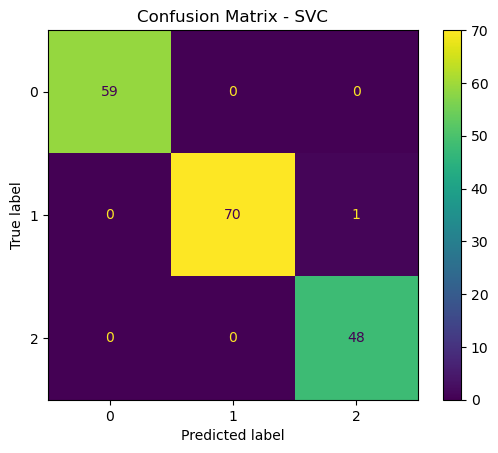

In [9]:
search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10, scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
search.fit(X,y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - SVC")
plt.grid(False)
plt.show()